In [1]:
import cdpm
from cdpm import CondDirichletProcessMix
import numpy as np
import numpy.linalg as nplin
import scipy.linalg as scilin
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import pandas as pd
from bayesiankalman import mcmc
import xarray as xr

In [2]:
%matplotlib inline
plt.style.use('seaborn-talk')
np.set_printoptions(precision=3)
pd.set_option('precision',np.get_printoptions()['precision'])

In [3]:
data_dim = 100
regressor_dim = 2
regressand_dim = 1
percentiles = (5, 50, 95)
num_draws = 400

In [4]:
prior = {"comp": {"coeff": {"mean": list(np.ravel(np.zeros((regressand_dim)))),
                            "cov" : list(np.ravel(np.eye(regressand_dim)))},
                  "precn": {"shape": [1/2], "scale": [1/2]}},
         "alpha": {"A_h": {"lambda": [1], "eta": [.5], "eta_1": [.5], "d_rescaling": [2]},
                  "tau_alpha": {"nu": [2]}},
         "cluster_id" : {"cluster_id": {"cluster_id": []}} # I define the prior for cluster_id this way because it is actually implicitelty
                                            # defined by alpha, but I want to be able to choose not to draw it, and it 
                                            # needs to have the same form as the other forms to be able to be passed
                                            # to C++. 
        }


## Simulate the data from cdpm

In [5]:
regressor = np.random.standard_normal((1, regressor_dim))

In [6]:
regressand = np.random.standard_normal((1, regressand_dim))

In [7]:
model = cdpm.simulate(1, np.asarray([[-1, -0.15]]).T, 1, 1, 1, regressor[0], regressand[0], data_dim, prior, 
                      max_num_comps=1)

In [8]:
prior = {"comp": {"coeff": {"mean": list(np.ravel(np.zeros((regressand_dim)))),
                            "cov" : list(np.ravel(np.eye(regressand_dim)))},
                  "precn": {"shape": [1/2], "scale": [1/2]}},
         "alpha": {"A_h": {"lambda": [1], "eta": [.5], "eta_1": [.5], "d_rescaling": [2]},
                  "tau_alpha": {"nu": [2]}},
         "cluster_id" : {"cluster_id": {"cluster_id": []}} # I define the prior for cluster_id this way because it is actually implicitelty
                                            # defined by alpha, but I want to be able to choose not to draw it, and it 
                                            # needs to have the same form as the other forms to be able to be passed
                                            # to C++. 
        }


In [9]:
model.cluster_dim

1

In [10]:
# use simulated series as the data
true_regressand = model.regressand
true_regressor = model.regressor
cluster_dim = model.cluster_dim
true_tau_vec = model.tau_vec
true_cluster_id = model.cluster_id
true_beta = model.coeffs
true_alpha = model.alpha
true_A_vec = model.A_vec
true_tau_alpha = model.alpha_tau

## Estimation

In [11]:
init_alpha_mat = np.random.standard_normal((data_dim, cluster_dim))
init_cluster_id_vec = np.random.randint(size=data_dim, low=0, high=cluster_dim)
init_beta = np.random.standard_normal((cluster_dim, regressor_dim, regressand_dim))
init_tau_vec = np.abs(np.random.standard_normal(cluster_dim))
init_A_vec = np.abs(np.random.standard_normal(cluster_dim))
alpha_tau = 1

using CondDirichletProcessMix, we can generate a posterior draw of (alpha, cluster_id_vec, beta, tau_vec, A_vec, 
tau_alpha) 

In [12]:
model_cdpm = CondDirichletProcessMix(model.alpha, model.cluster_id, model.coeffs, model.A_vec, model.tau_vec, alpha_tau, 
                                     true_regressor, true_regressand)

In [13]:
alpha_mat_draws = []
cluster_id_draws = np.empty((num_draws, data_dim))
beta_draws = [] 
tau_draws = []
A_draws = []
tau_alpha_draws = np.empty((num_draws, 1))

In [14]:
# sometimes, it breaks since SVD is not possible.
for draw_idx in tqdm(range(num_draws)):
    post_draws = model_cdpm(prior, 1)
    alpha_mat_draws.append(post_draws[0])
    cluster_id_draws[draw_idx] = post_draws[1]
    beta_draws.append(post_draws[2])
    tau_draws.append(post_draws[3])
    A_draws.append(post_draws[4])
    tau_alpha_draws[draw_idx] = post_draws[5]

100%|██████████| 400/400 [00:39<00:00, 10.16it/s]     | 3/400 [00:00<00:15, 25.20it/s]           20%|█▉        | 78/400 [00:31<06:53,  1.28s/it]


## Simulation results

### Cluster Identity

In [15]:
cluster_id_quantiles = np.percentile(cluster_id_draws, percentiles, axis=0)

In [16]:
np.corrcoef([cluster_id_quantiles[1], true_cluster_id])[0,-1]

/home/sangrey/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


nan

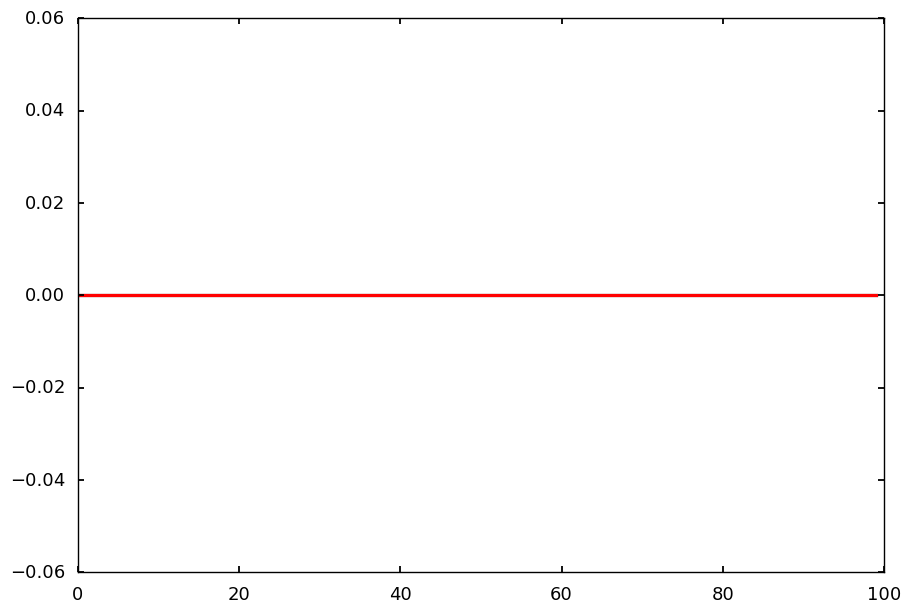

In [17]:
cluster_id_comparison_fig, cluster_id_comparison_ax = plt.subplots(1,1)
mcmc.fan_plot(cluster_id_comparison_ax, pd.DataFrame(cluster_id_draws).T, percentiles, c='black')
cluster_id_comparison_ax.plot(true_cluster_id, c='red')

### Betas

In [18]:
def combine_estimates(estimate, shape_func):
    if estimate.shape[0] == cluster_dim:
        return xr.DataArray(estimate)
    elif estimate.shape[0] < cluster_dim:
        return xr.concat([xr.DataArray(estimate), xr.DataArray(np.full(shape_func(estimate.shape[0]), np.nan))])
    else: 
        return xr.DataArray(estimate)[:cluster_dim]

In [19]:
def beta_shape(val_dim):
    return cluster_dim - val_dim, regressor_dim, regressand_dim

In [21]:
beta_xr = xr.concat([combine_estimates(val, beta_shape) for val in beta_draws], dim='Draw')
beta_xr = beta_xr.rename({'dim_0': 'Cluster', 'dim_1': 'Regressor', 'dim_2': 'Regressand'})
beta_pcts = xr.DataArray(np.nanpercentile(beta_xr, percentiles, axis=0), 
                         dims=['Pct', 'Cluster', 'Regressor', 'Regressand'], 
                         coords = {'Pct': [str(val) + '%' for val in percentiles]})
for val in beta_pcts:
    print(str(val.coords['Pct'].values) + ' Pct')
    print(val.values.swapaxes(0,-1))
print('\nThe true coefficients are: \n' + str(true_beta.swapaxes(0, 2)))
print('\nThe root mean square error is ' + str(mcmc.rmse(beta_pcts.loc['50%'][:true_beta.shape[0]], true_beta)))

5% Pct
[[[-1.21 ]
  [-0.386]]]
50% Pct
[[[-1.066]
  [-0.244]]]
95% Pct
[[[-0.936]
  [-0.122]]]

The true coefficients are: 
[[[-1.  ]
  [-0.15]]]

The root mean square error is 0.0813069097804


## Component Precisions ##

In [22]:
tau_vec_df = pd.concat([pd.DataFrame(val) for val in tau_draws], axis=1)
tau_vec_pcts = pd.DataFrame(np.nanpercentile(tau_vec_df, percentiles, axis=1), 
                            index=[str(val) + '%' for val in percentiles])
print(tau_vec_pcts)
print('\nThe true precisions are: \n' + str(true_tau_vec))
print('\nThe root mean square error is ' + str(mcmc.rmse(tau_vec_pcts.loc['50%'][:true_tau_vec.shape[0]], 
                                                         true_tau_vec)))

         0
5%   0.735
50%  0.940
95%  1.174

The true precisions are: 
[ 1.]

The root mean square error is 0.0602872994868


## Alpha Matrix 

In [23]:
def alpha_shape(val_dim):
    return (data_dim, cluster_dim - val_dim)

In [24]:
alpha_empty_xr = xr.DataArray(np.full((data_dim, cluster_dim), np.nan)) 
alpha_xr = xr.concat((combine_estimates(np.asarray(val).T, alpha_shape).T 
                      for val in alpha_mat_draws), 'Draw').rename({'dim_0': 'Cluster', 'dim_1': 'Time'})
alpha_pcts = xr.DataArray(np.nanpercentile(alpha_xr, percentiles, axis=0), 
                         dims=['Pct', 'Time', 'Cluster'],
                         coords = {'Pct': [str(val) + '%' for val in percentiles]})

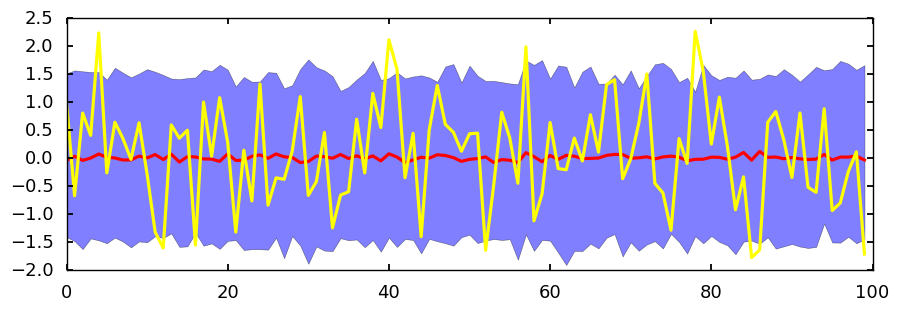

In [31]:
alpha_comparison_fig = plt.figure()
for i in range(cluster_dim):
    alpha_comparison_ax = alpha_comparison_fig.add_subplot(2, max(1, cluster_dim // 2), i+1)
    mcmc.fan_plot(alpha_comparison_ax, alpha_xr.isel(Cluster=i).to_pandas().T, percentiles, c='red')
    alpha_comparison_ax.plot(true_alpha[:,i], c='yellow')

In [32]:
median_alpha = alpha_pcts.sel(Pct='50%').to_pandas()
print('\nThe root mean square error is ' + str(mcmc.rmse(median_alpha, true_alpha)))


The root mean square error is 0.917512349956


In [33]:
A_vec_df = pd.concat([pd.DataFrame(val) for val in A_draws], axis=1)
A_vec_pcts = pd.DataFrame(np.nanpercentile(A_vec_df, percentiles, axis=1), 
                            index=[str(val) + '%' for val in percentiles])
print(A_vec_pcts)
print('\nThe true A_h values are: \n' + str(true_A_vec))
print('\nThe root mean square error is ' + str(mcmc.rmse(A_vec_pcts.loc['50%'][:true_A_vec.shape[0]],true_A_vec)))

         0
5%   0.508
50%  0.983
95%  3.045

The true A_h values are: 
[ 1.]

The root mean square error is 0.0166983427096


In [34]:
tau_alpha_pcts = pd.DataFrame(np.nanpercentile(tau_alpha_draws, percentiles, axis=0), 
                            index=[str(val) + '%' for val in percentiles])
print(tau_alpha_pcts)
print('\nThe true tau_alpha value is: \n' + str(true_tau_alpha))
print('\nThe root mean square error is ' + str(mcmc.rmse(tau_alpha_pcts.loc['50%'],true_tau_alpha)))

         0
5%   0.554
50%  1.233
95%  4.500

The true tau_alpha value is: 
1.0

The root mean square error is 0.232520259982
